In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
from tensorflow.keras.layers import Dense,Bidirectional,GRU,LSTM,SimpleRNN,Flatten,Lambda,Conv1D,MaxPooling1D,BatchNormalization,Activation,Concatenate,Input,Add
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.models import Model,Sequential
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error

In [ ]:
class timeSeriesPredict:
  def __init__(self,countryName):
    self.country = countryName
  series = []
  model = 0
  x = []
  y = []
  x_train = []
  y_train = []
  x_val = []
  y_val = []
  split_time = 0
  lr = .001
  optimizer = Adam(lr)
  loss = tf.keras.losses.MeanSquaredError()
  callbacks = []
  epochs = 500
  history = None


In [ ]:
def get_series(file_path):
  sdate = datetime.datetime.strptime(starting_date, "%d%m%Y").date()
  with open(file_path) as f:
    reader = csv.reader(f,delimiter=',')
    next(reader)
    series = []
    c = 0
    dates = []
    for i in reader:
      try : 
        tmp = []
        tmp.append(float(i[5]))
        series.append(np.array(tmp))
        dates.append(sdate + datetime.timedelta(days = c))
        c += 1
      except:
        series.append(np.array([0]))
        dates.append(sdate + datetime.timedelta(days = c))
        c += 1
        continue
    series = np.vstack(series)
    return series,dates



def create_windowed_dataset(series, window,begin):
  # series is a numpy array with shape (m,n_features)
  # this function returns x and y
  # x -> windowed data, numpy array of shape (m,n_features)
  # y -> labels for x, numpy array with shape(m,)
  m, n_features = series.shape
  i = begin
  x = []
  y = []
  while i < m :
    tmp = np.zeros((window,n_features))
    j = 0 if i-window >= 0 else window - i;
    tmp[j:window,:] = series[max(0,i-window):i,:] 
    x.append(tmp)
    y.append(series[i])
    i += 1
  return np.array(x), np.array(y)

def train_test_split(ratio,x,y):
  split_time = int(x.shape[0] * ratio)
  return x[0:split_time,:],x[split_time:,:],y[0:split_time],y[split_time:]

def moving_average(series,window):
  x = []
  m = series.shape[0]
  for i in range(m):
    b = i - window//2
    e = i + window//2
    inc = 0 if b > 0 else -b
    e += inc
    b += inc
    dec = 0 if e < m else e-m+1
    b -= dec
    e -= dec
    # print(b,e)
    x.append(np.sum(series[b:e+1,:]) / window)
  return np.array(np.expand_dims(x,1)) 

def plot(series,dates,fig=(5,3),label=None,title=None,interval=10,rotation=30,xlabel="Time",ylabel="New Cases"):
  fig = plt.figure(figsize = fig)
  ax = fig.add_subplot(111)
  plt.style.use("fivethirtyeight")

  n_lines = 2
  diff_linewidth = 1.05
  alpha_value = 0.1

  if dates != None:
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    ax.plot(dates,series,label = label,color='#00008B')
    #for n in range(1, n_lines+1):
     # ax.plot(dates,series,label = label,color='#00008B',
      #        linewidth=2+(diff_linewidth*n),
       #       alpha=alpha_value
        #      )
  else:
    ax.plot([*range(1,len(series)+1)],series,label = label,color='#00008B')
   # for n in range(1, n_lines+1):
    #  ax.plot([*range(1,len(series)+1)],series,label = label,color='#00008B',
     #         linewidth=2+(diff_linewidth*n),
      #        alpha=alpha_value
       #       )

  
  
              #ax=ax,
              #color=colors
  i=0
  for column in (series):
    ax.fill_between(x=i if dates==None else dates[i],
                    y1=column,
                    y2=[0] * len(series),
                    color='#00008B',
                    alpha=0.2)
    i=i+1
  

  
 # ax.plot(series,label = label,color='#FE53BB')
  ax.grid(color='#2A3459')
  ax.set_title(title,color='red')
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  # ax.spines['bottom'].set_color('red')
  # ax.spines['top'].set_color('red')
  ax.xaxis.label.set_color('black')
  ax.tick_params(axis='x', colors='black',rotation=rotation)
  ax.yaxis.label.set_color('green')
  ax.tick_params(axis='y', colors='green')
  if label != None:
    ax.legend()
  plt.show()

def comp_plot(series1,series2,dates,figsize=(20,10),flabel='train',slabel='val',title=None,interval=10,rotation=30,pred=[]):

  
 # df.plot(marker='o', ax=ax, color=colors)

  plt.style.use("fivethirtyeight")
  
  


  fig = plt.figure(figsize=figsize)
  ax = fig.add_subplot(111)

  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
  plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=interval))

  ax.grid(color='#2A3459')
  #ax.plot(series1,label = flabel)
  ax.plot(dates,series1,label = flabel,color='#00008B')
  #n_lines = 2
  #diff_linewidth = 1.05
  #alpha_value = 0.1
 
  i=0
 # for column in (series1):
  #  ax.fill_between(x=dates[i],
   #                 y1=column,
   #                 y2=[0] * len(series1),
    #                color='#00008B',
     #               alpha=0.2)
    #i=i+1




  
  z = dates+pred
  ax.plot(z,series2,label = slabel,color='#FFA500')
  
 
  i=0
  #for column in (series2):
   # ax.fill_between(x=z[i],
    #                y1=column,
     #               y2=[0] * len(series2),
      #              color='#FFA500',
       #             alpha=0.2)
    #i=i+1



  ax.set_xlabel('Time')
  ax.set_ylabel('New Cases')
  ax.set_title(title,color='red')
  # ax.spines['bottom'].set_color('red')
  # ax.spines['top'].set_color('red')
  ax.xaxis.label.set_color('black')
  ax.tick_params(axis='x', colors='black',rotation=rotation)
  ax.yaxis.label.set_color('green')
  ax.tick_params(axis='y', colors='green')
  #ax.legend()
  plt.legend(['True Cases','Predicted Cases'])

  plt.show()


def forecast(model,x,window,days,tmn,tstd):
  y = model.predict(x)
  print(y.shape)
  for i in range(days) : 
    m = y.shape[0]
    tmp = y[-window:m]
    tmp = np.expand_dims(tmp,[0])
    tmp = (tmp - tmn) / tstd
    y = np.append(y,model.predict(tmp),axis= 0)
  
  return y


def mape(y1,y2):
  
  error=0
  cnt=0
  for i in range(y1.shape[0]):
    if y1[i]!=0:
      error=error+np.abs(y1[i]-y2[i])/y1[i]
      cnt=cnt+1
  error=error/cnt
  #print(error)
  error=error*100
  #error=convert_to_tensor(error)

  return error


def train_model(country):
  tf.keras.backend.clear_session()
  country.model.compile(loss=country.loss,metrics=['mse'],optimizer=country.optimizer)
  history = country.model.fit(x=country.x_train,y=country.y_train, validation_data = (country.x_val,country.y_val), epochs=country.epochs,verbose=1,batch_size=300,callbacks=country.callbacks)
  country.history = history
  # plot(history.history['mse'],None,fig=(12,6))
  # plot(history.history['val_mse'],None,fig=(12,6))
  

def show_plots(country):
  # plot(country.history.history['mse'],None,fig=(12,6),label='train_mse', title='train mse',xlabel="epochs",ylabel="mse")
  # plot(country.history.history['val_mse'],None,fig=(12,6), label='val_mse', title='val mse')
  y_actual=country.y
  y_predicted=country.model.predict(country.x)
  nRMSE_train=mean_squared_error(y_actual, y_predicted, squared=False)/np.mean(y_predicted)
  MAPE_train=mape(y_actual,y_predicted)
  comp_plot(country.y,country.model.predict(country.x),country.dates,
            title='entire series prediction',interval=interval,rotation=rotation)
  
  y_actual=country.y_val
  y_predicted=country.model.predict(country.x_val)
  nRMSE_val=mean_squared_error(y_actual, y_predicted, squared=False)/np.mean(y_predicted)
  MAPE_val=mape(y_actual,y_predicted)
  comp_plot(country.y_val,country.model.predict(country.x_val),country.dates[country.split_time:],
            title='Validation',interval=3,rotation=rotation)
  prediction_dates = []
  last = country.dates[-1];
  for i in range(1,41):
    prediction_dates.append(last+datetime.timedelta(days=i))
  comp_plot(country.y,forecast(country.model,country.x,window_size,40,0,1),country.dates,
            figsize=(12,10),title='Forecast',interval=interval,rotation=rotation,pred=prediction_dates)
  return nRMSE_train,nRMSE_val,MAPE_train,MAPE_val


In [ ]:
def get_model():
  model = Sequential()
  model.add((GRU(50,return_sequences=True,activation='relu', input_shape=(window_size, n_features))))
  model.add((GRU(20,activation='relu')))
  model.add(Dense(1))
  return model


In [ ]:
ratio = .9
window_size = 8
n_features = 1
interval = 10
rotation = 45

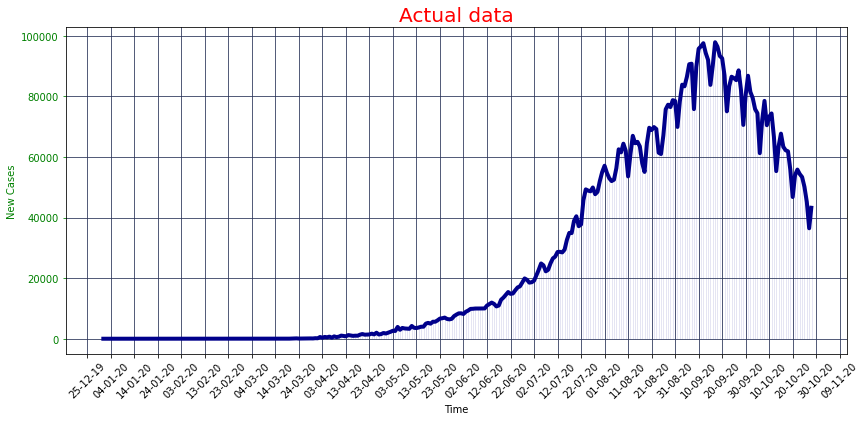

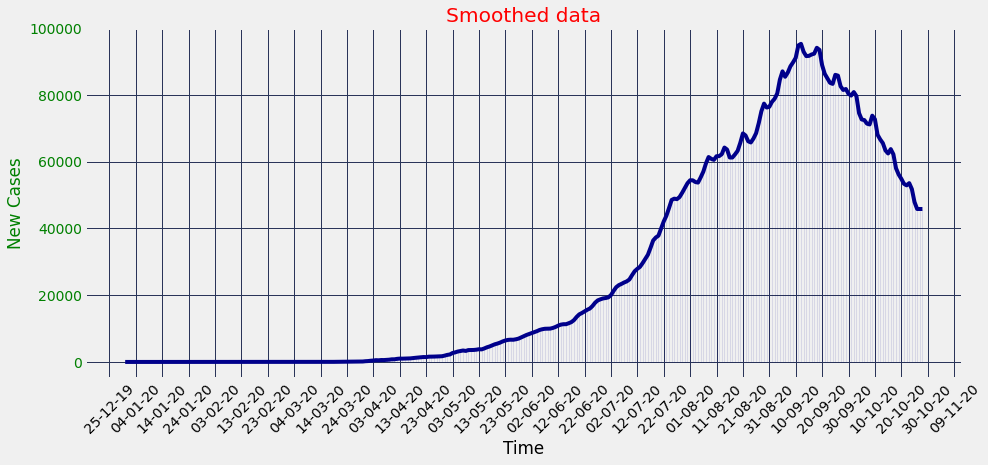

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 8, 50)             7950      
_________________________________________________________________
gru_1 (GRU)                  (None, 20)                4320      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 12,291
Trainable params: 12,291
Non-trainable params: 0
_________________________________________________________________


In [ ]:
starting_date = "31122019"
india = timeSeriesPredict("india")
india.series,india.dates = get_series('/content/India.csv')
plot(india.series,india.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
india.series = moving_average(india.series,5)
plot(india.series,india.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
india.x,india.y = create_windowed_dataset(india.series,8,0)
india.x_train,india.x_val,india.y_train,india.y_val = train_test_split(ratio,india.x,india.y)
india.model = get_model()
india.model.summary()
india.epochs = 1000
india.split_time = int(india.x.shape[0] * ratio)

In [ ]:
train_model(india)

Epoch 1/1000
1/1 [==============================] - 0s 395ms/step - loss: 1525685248.0000 - mse: 1525685248.0000 - val_loss: 4743877632.0000 - val_mse: 4743877632.0000
Epoch 2/1000
1/1 [==============================] - 0s 22ms/step - loss: 1513991424.0000 - mse: 1513991424.0000 - val_loss: 4633645568.0000 - val_mse: 4633645568.0000
Epoch 3/1000
1/1 [==============================] - 0s 21ms/step - loss: 1487016448.0000 - mse: 1487016448.0000 - val_loss: 4597574144.0000 - val_mse: 4597574144.0000
Epoch 4/1000
1/1 [==============================] - 0s 21ms/step - loss: 1476591104.0000 - mse: 1476591104.0000 - val_loss: 4561369600.0000 - val_mse: 4561369600.0000
Epoch 5/1000
1/1 [==============================] - 0s 22ms/step - loss: 1466322944.0000 - mse: 1466322944.0000 - val_loss: 4525135872.0000 - val_mse: 4525135872.0000
Epoch 6/1000
1/1 [==============================] - 0s 20ms/step - loss: 1456059904.0000 - mse: 1456059904.0000 - val_loss: 4315608576.0000 - val_mse: 4315608576.00

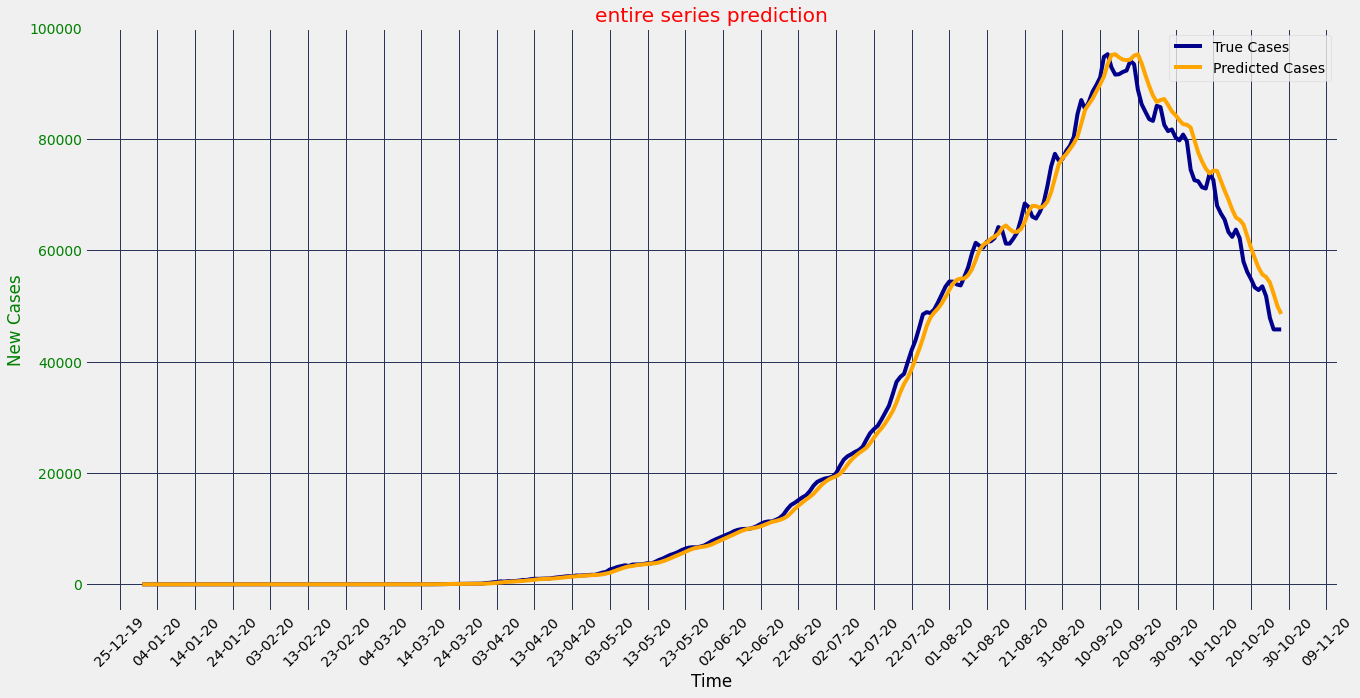

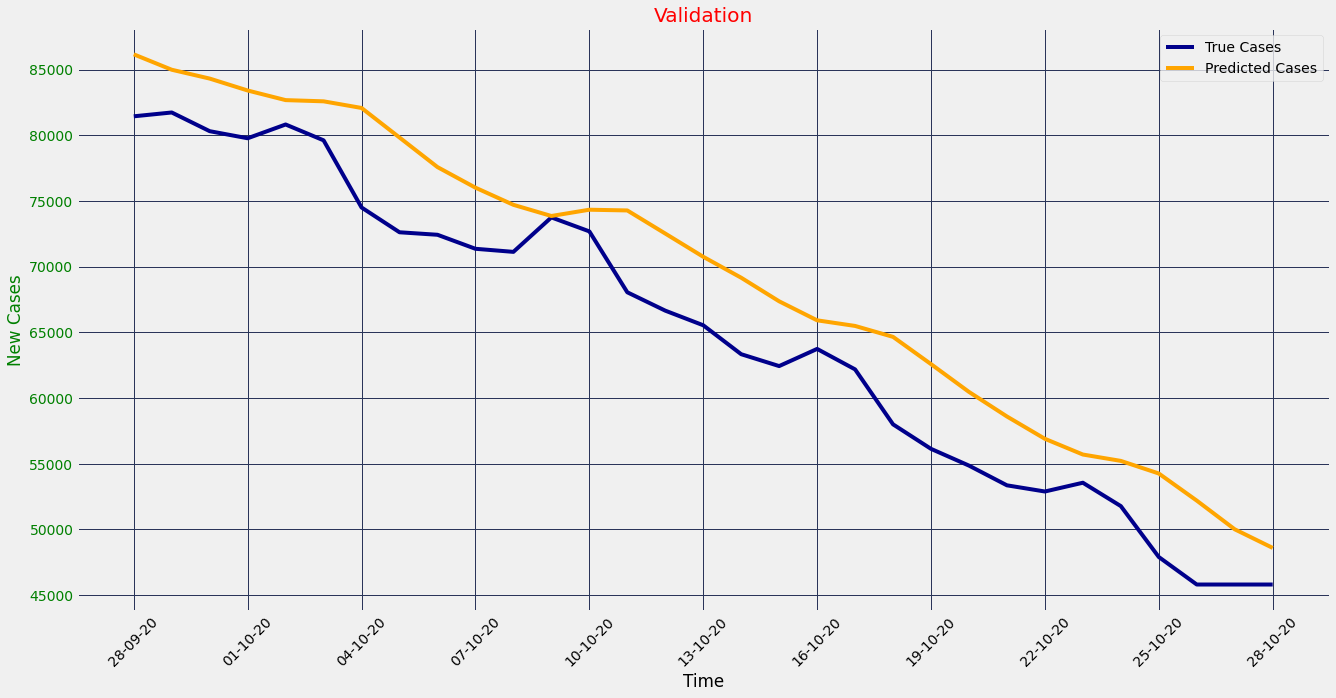

(303, 1)


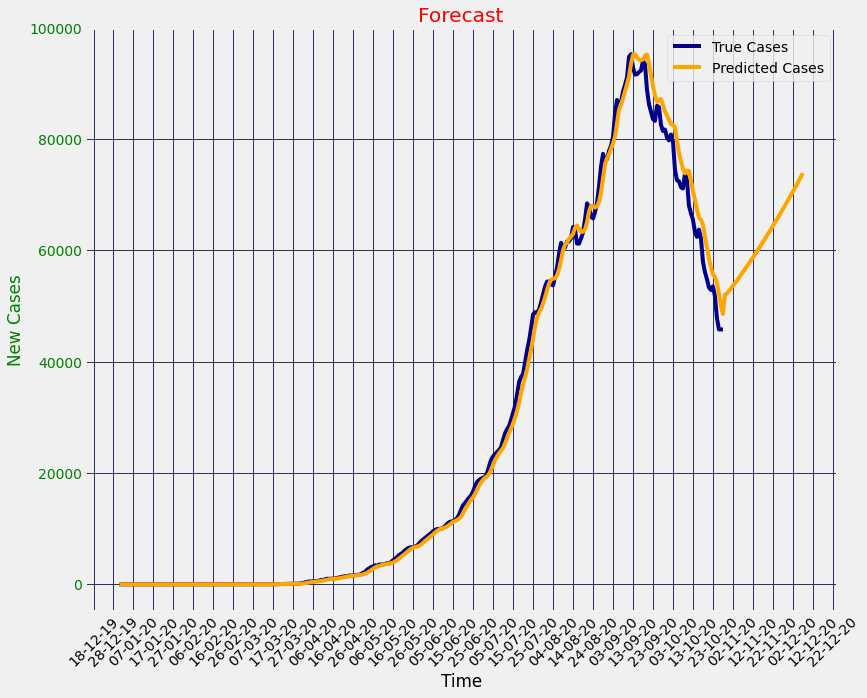

(0.07795396240594976,
 0.06889101121449118,
 array([9.31181659]),
 array([7.16100915]))

In [ ]:
show_plots(india)

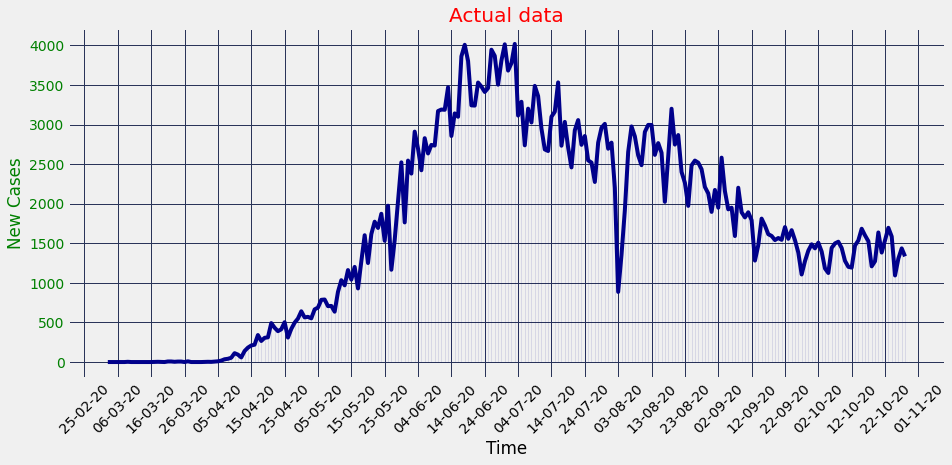

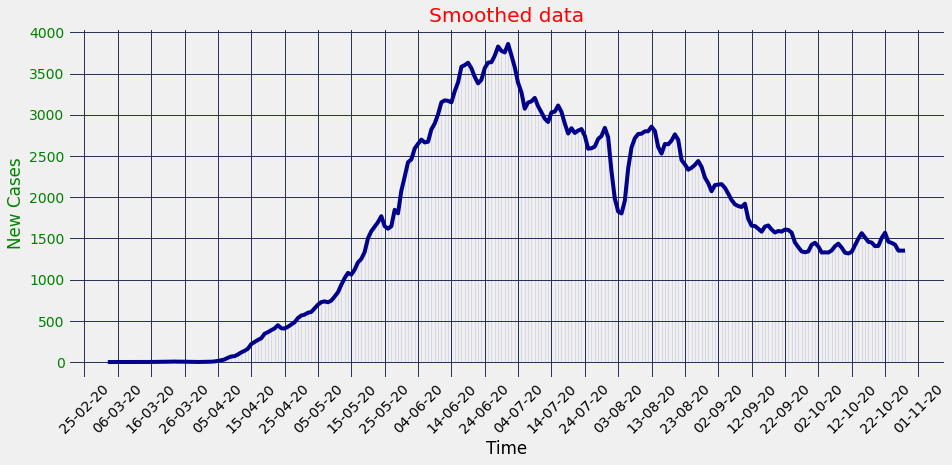

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 8, 50)             7950      
_________________________________________________________________
gru_1 (GRU)                  (None, 20)                4320      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 12,291
Trainable params: 12,291
Non-trainable params: 0
_________________________________________________________________


In [ ]:
starting_date = "03032020"
bangladesh = timeSeriesPredict("Bangladesh")
country = bangladesh
country.series,country.dates = get_series('/content/Bangladesh.csv')
plot(country.series,country.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
country.series = moving_average(country.series,5)
plot(country.series,country.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
country.x,country.y = create_windowed_dataset(country.series,8,0)
country.x_train,country.x_val,country.y_train,country.y_val = train_test_split(ratio,country.x,country.y)
country.model = get_model()
country.model.summary()
country.epochs = 1000
country.split_time = int(country.x.shape[0] * ratio)

In [ ]:
train_model(country)

Epoch 1/1000
1/1 [==============================] - 0s 349ms/step - loss: 4089014.5000 - mse: 4089014.5000 - val_loss: 1807811.6250 - val_mse: 1807811.6250
Epoch 2/1000
1/1 [==============================] - 0s 20ms/step - loss: 3910067.0000 - mse: 3910067.0000 - val_loss: 1717834.8750 - val_mse: 1717834.8750
Epoch 3/1000
1/1 [==============================] - 0s 20ms/step - loss: 3714884.7500 - mse: 3714884.7500 - val_loss: 1614366.6250 - val_mse: 1614366.6250
Epoch 4/1000
1/1 [==============================] - 0s 20ms/step - loss: 3461566.2500 - mse: 3461566.2500 - val_loss: 1381510.8750 - val_mse: 1381510.8750
Epoch 5/1000
1/1 [==============================] - 0s 22ms/step - loss: 2969101.0000 - mse: 2969101.0000 - val_loss: 1279181.1250 - val_mse: 1279181.1250
Epoch 6/1000
1/1 [==============================] - 0s 21ms/step - loss: 2758417.7500 - mse: 2758417.7500 - val_loss: 1092441.6250 - val_mse: 1092441.6250
Epoch 7/1000
1/1 [==============================] - 0s 20ms/step - lo

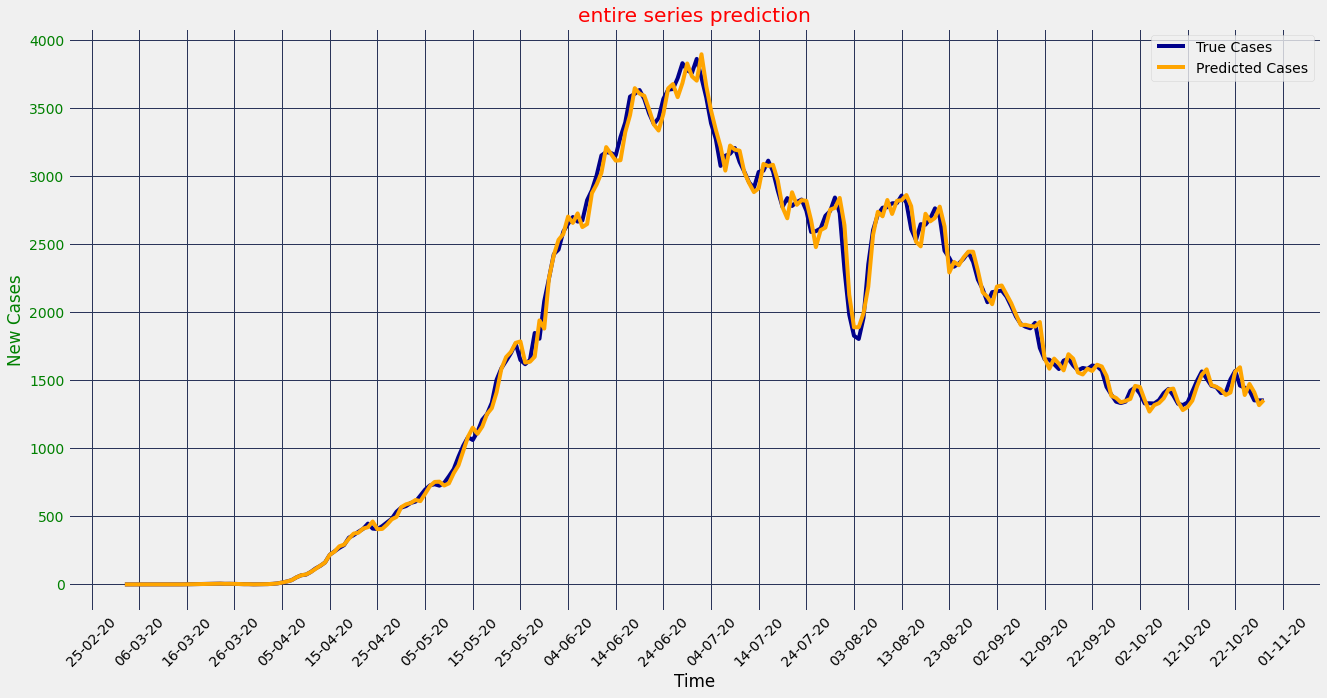

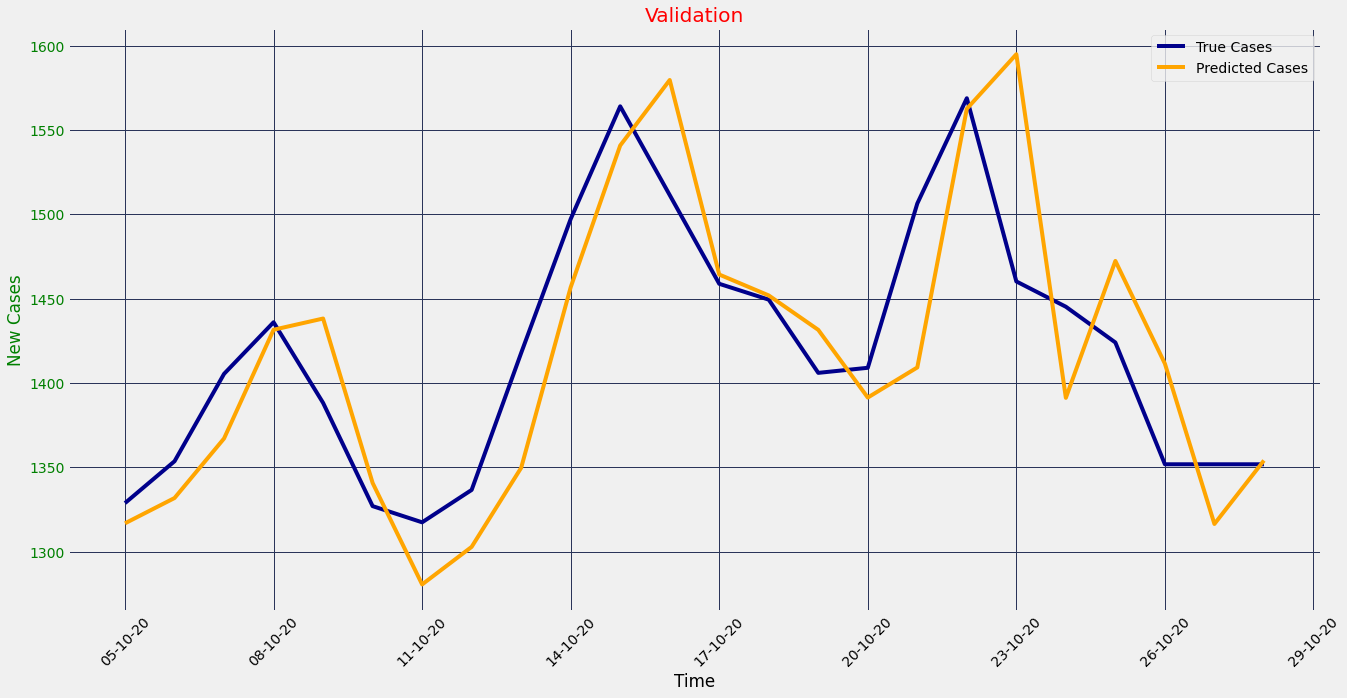

(240, 1)


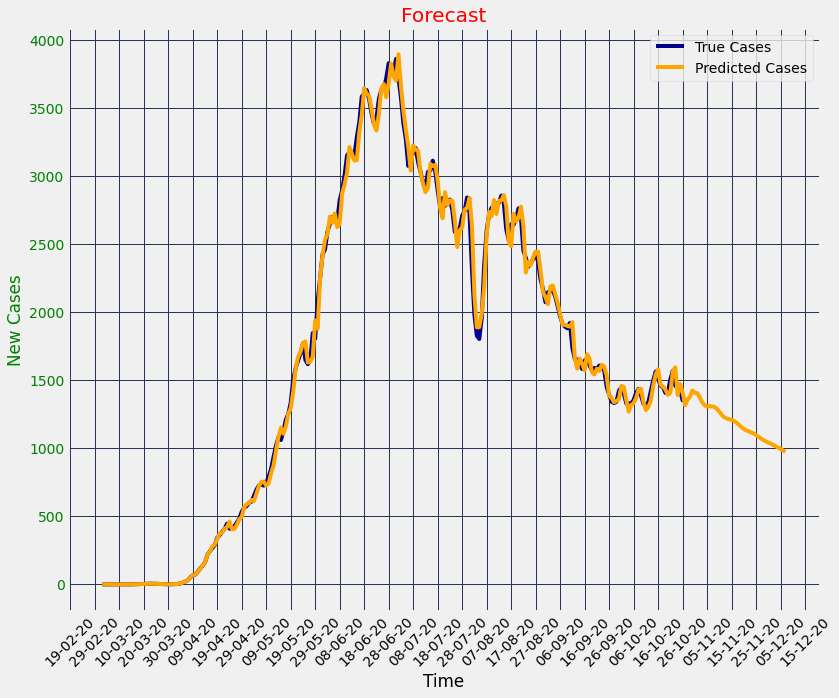

(0.039322313924958364,
 0.03454759260876261,
 array([2.91704632]),
 array([2.62609545]))

In [ ]:
show_plots(bangladesh)

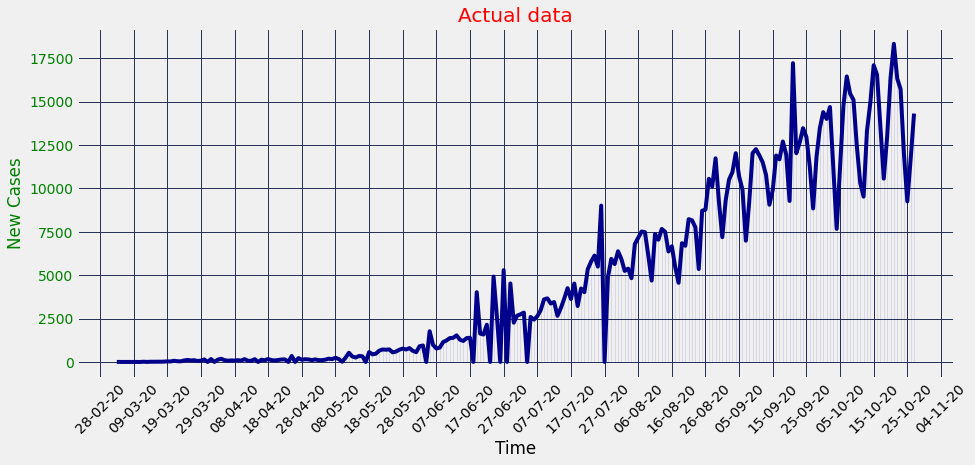

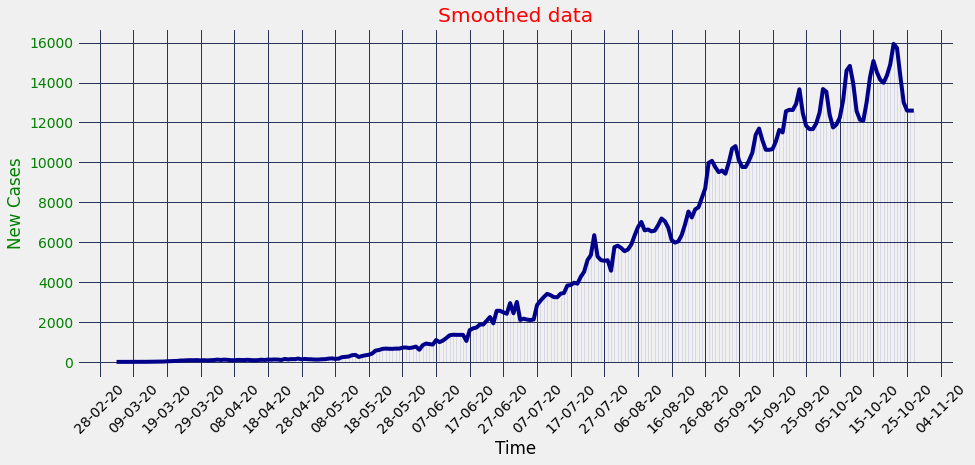

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 8, 50)             7950      
_________________________________________________________________
gru_1 (GRU)                  (None, 20)                4320      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 12,291
Trainable params: 12,291
Non-trainable params: 0
_________________________________________________________________


In [ ]:
starting_date = "04032020"
argentina = timeSeriesPredict("Argentina")
country = argentina
country.series,country.dates = get_series('/content/Argentina.csv')
plot(country.series,country.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
country.series = moving_average(country.series,5)
plot(country.series,country.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
country.x,country.y = create_windowed_dataset(country.series,8,0)
country.x_train,country.x_val,country.y_train,country.y_val = train_test_split(ratio,country.x,country.y)
country.model = get_model()
country.model.summary()
country.epochs = 1000
country.split_time = int(country.x.shape[0] * ratio)

In [ ]:
train_model(argentina)

Epoch 1/1000
1/1 [==============================] - 0s 338ms/step - loss: 35277844.0000 - mse: 35277844.0000 - val_loss: 208254848.0000 - val_mse: 208254848.0000
Epoch 2/1000
1/1 [==============================] - 0s 21ms/step - loss: 34441348.0000 - mse: 34441348.0000 - val_loss: 198806192.0000 - val_mse: 198806192.0000
Epoch 3/1000
1/1 [==============================] - 0s 23ms/step - loss: 32909826.0000 - mse: 32909826.0000 - val_loss: 191923536.0000 - val_mse: 191923536.0000
Epoch 4/1000
1/1 [==============================] - 0s 23ms/step - loss: 31793530.0000 - mse: 31793530.0000 - val_loss: 182491824.0000 - val_mse: 182491824.0000
Epoch 5/1000
1/1 [==============================] - 0s 21ms/step - loss: 30367270.0000 - mse: 30367270.0000 - val_loss: 175712080.0000 - val_mse: 175712080.0000
Epoch 6/1000
1/1 [==============================] - 0s 20ms/step - loss: 29142212.0000 - mse: 29142212.0000 - val_loss: 167985968.0000 - val_mse: 167985968.0000
Epoch 7/1000
1/1 [===============

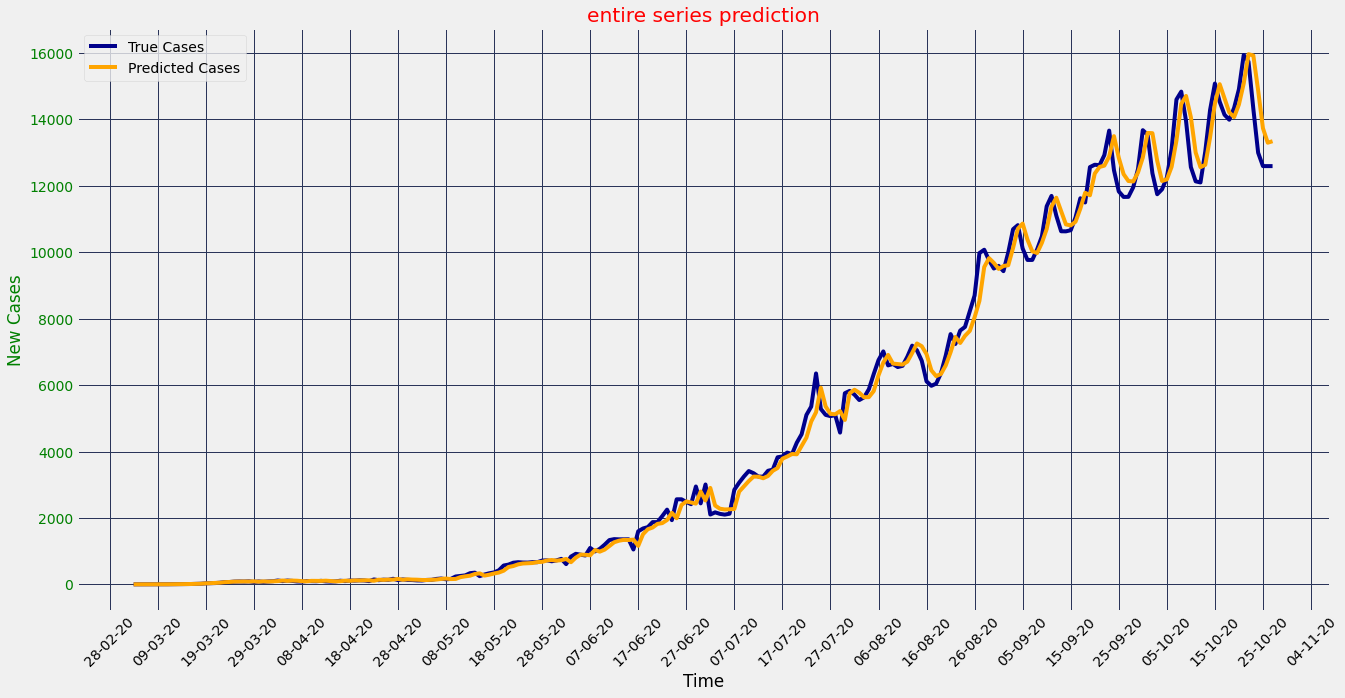

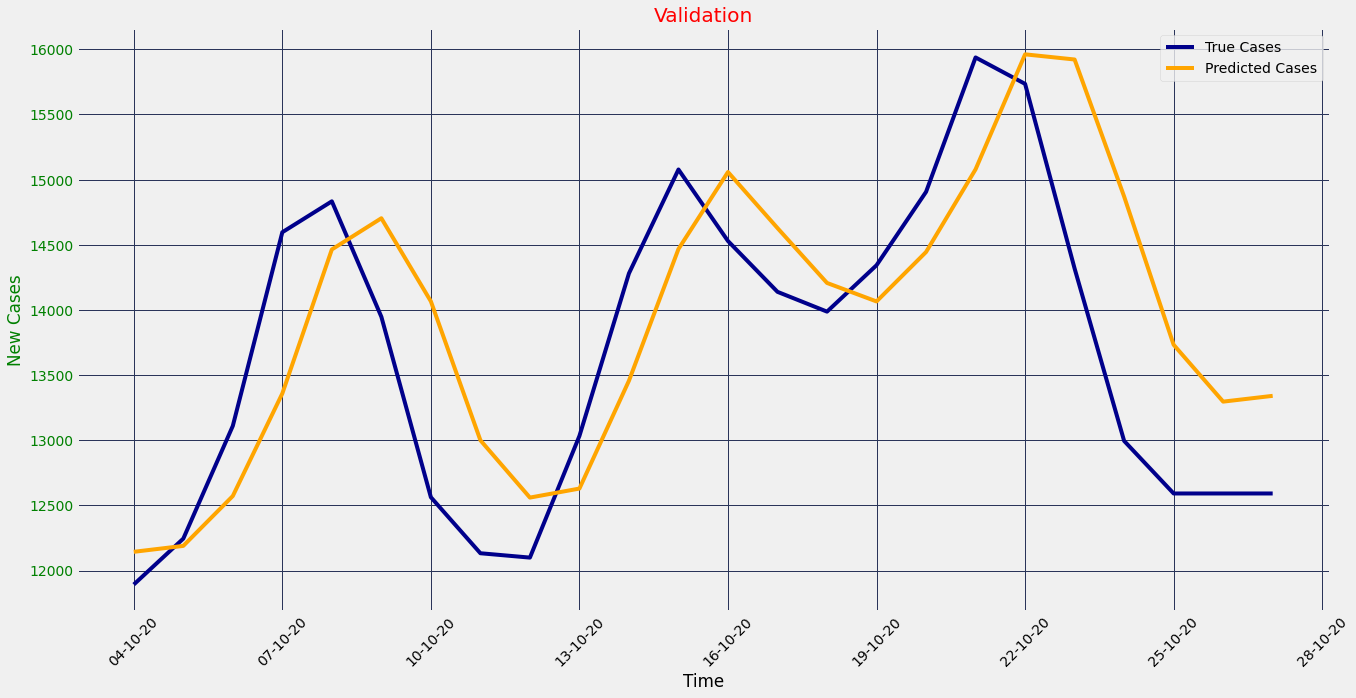

(238, 1)


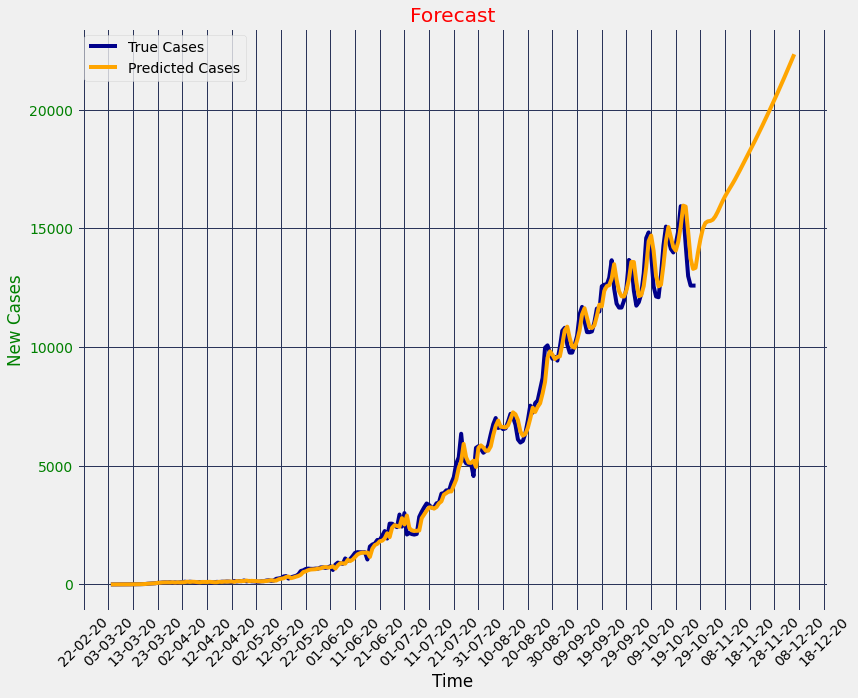

(0.08813678648297492,
 0.06066034561925472,
 array([7.28165733]),
 array([5.23583022]))

In [ ]:
show_plots(argentina)

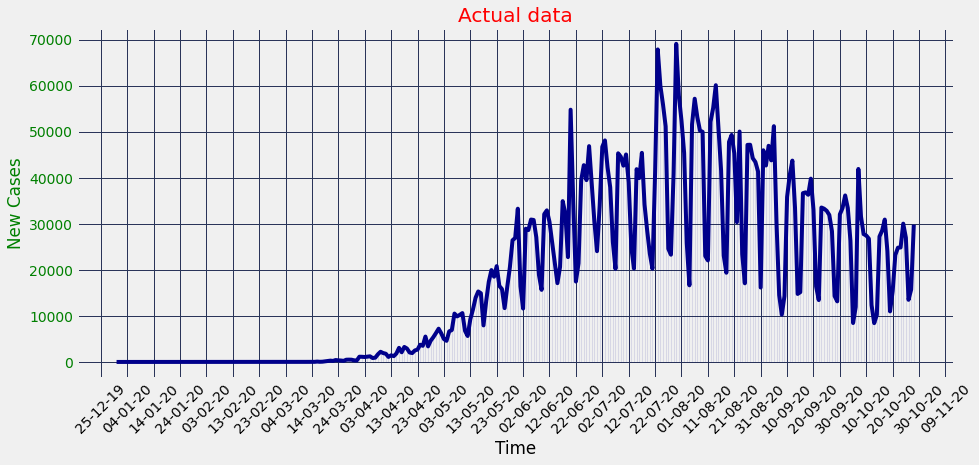

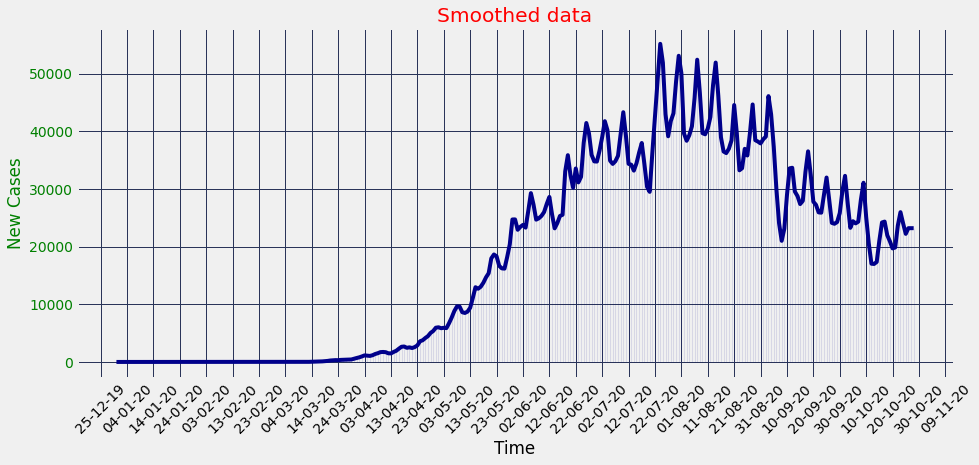

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 8, 50)             7950      
_________________________________________________________________
gru_1 (GRU)                  (None, 20)                4320      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 12,291
Trainable params: 12,291
Non-trainable params: 0
_________________________________________________________________


In [ ]:
starting_date = "31122019"
brazil = timeSeriesPredict("Brazil")
country = brazil
country.series,country.dates = get_series('/content/Brazil.csv')
plot(country.series,country.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
country.series = moving_average(country.series,5)
plot(country.series,country.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
country.x,country.y = create_windowed_dataset(country.series,8,0)
country.x_train,country.x_val,country.y_train,country.y_val = train_test_split(ratio,country.x,country.y)
country.model = get_model()
country.model.summary()
country.epochs = 1000
country.split_time = int(country.x.shape[0] * ratio)

In [ ]:
train_model(country)

Epoch 1/1000
1/1 [==============================] - 0s 326ms/step - loss: 578294912.0000 - mse: 578294912.0000 - val_loss: 535822656.0000 - val_mse: 535822656.0000
Epoch 2/1000
1/1 [==============================] - 0s 19ms/step - loss: 561831680.0000 - mse: 561831680.0000 - val_loss: 497748672.0000 - val_mse: 497748672.0000
Epoch 3/1000
1/1 [==============================] - 0s 19ms/step - loss: 522490528.0000 - mse: 522490528.0000 - val_loss: 432175360.0000 - val_mse: 432175360.0000
Epoch 4/1000
1/1 [==============================] - 0s 21ms/step - loss: 456412224.0000 - mse: 456412224.0000 - val_loss: 341090528.0000 - val_mse: 341090528.0000
Epoch 5/1000
1/1 [==============================] - 0s 20ms/step - loss: 362870720.0000 - mse: 362870720.0000 - val_loss: 353318144.0000 - val_mse: 353318144.0000
Epoch 6/1000
1/1 [==============================] - 0s 21ms/step - loss: 371746144.0000 - mse: 371746144.0000 - val_loss: 318874272.0000 - val_mse: 318874272.0000
Epoch 7/1000
1/1 [===

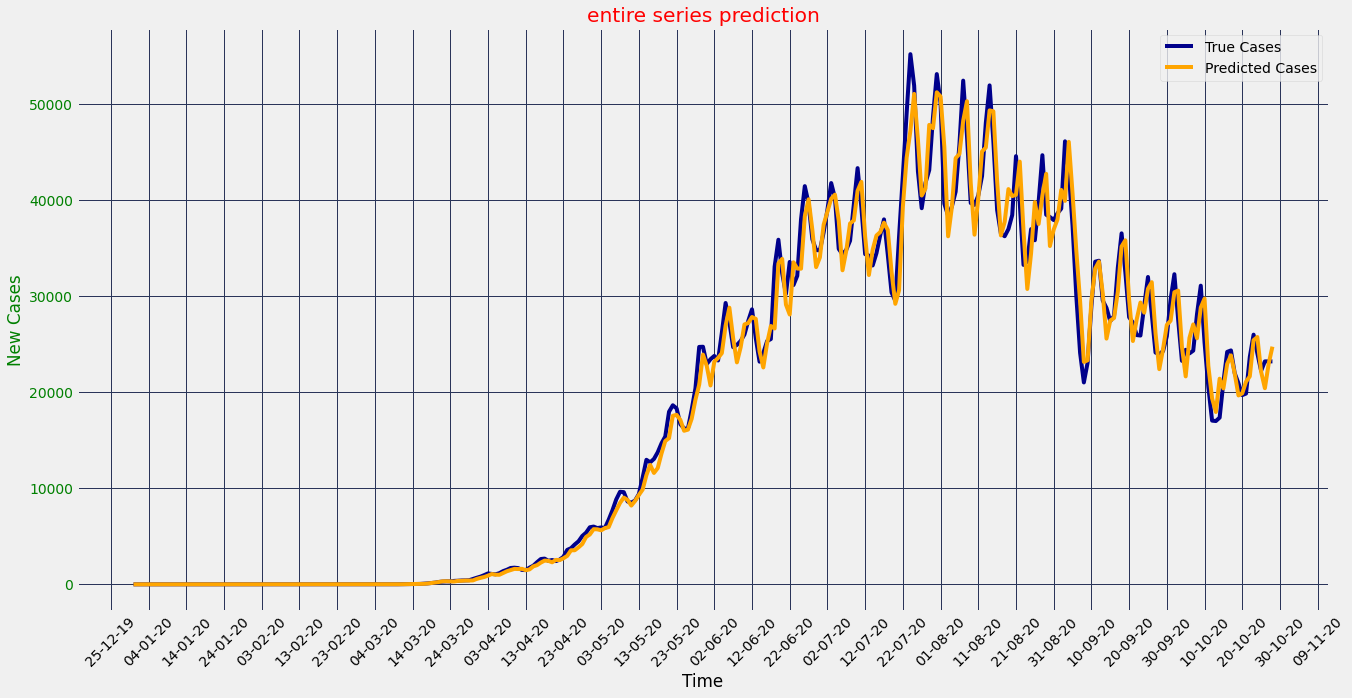

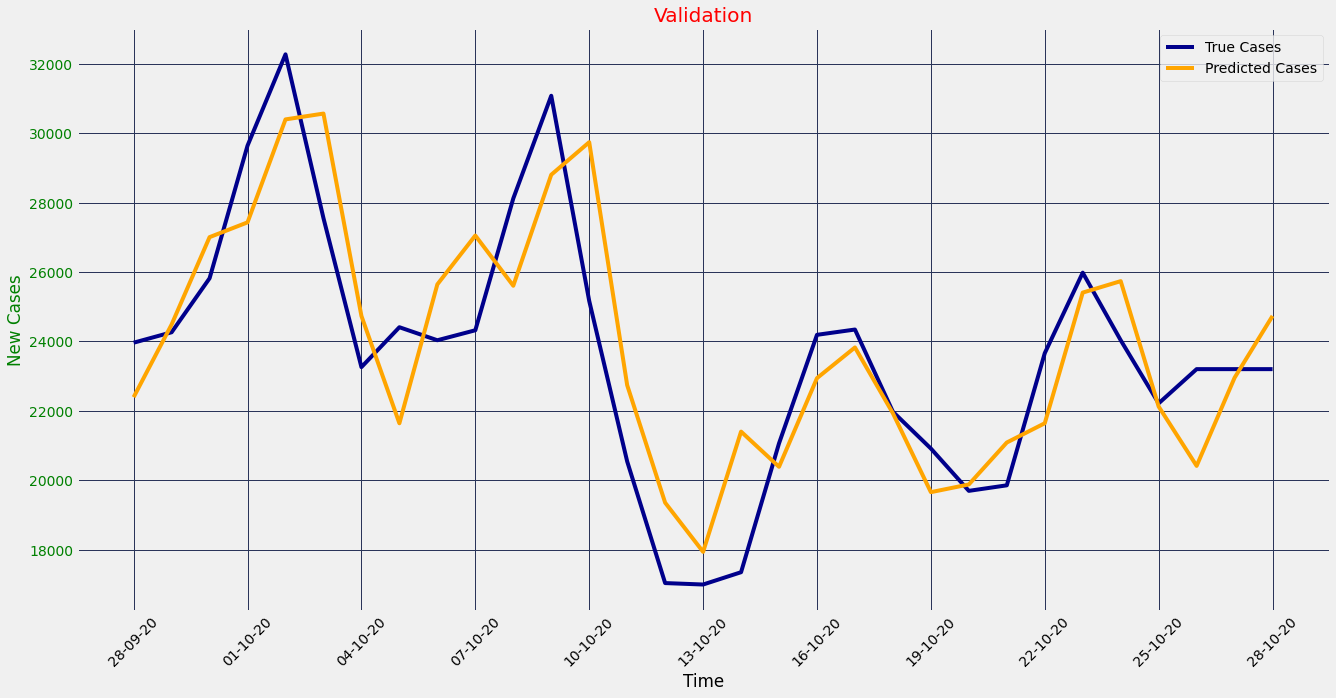

(303, 1)


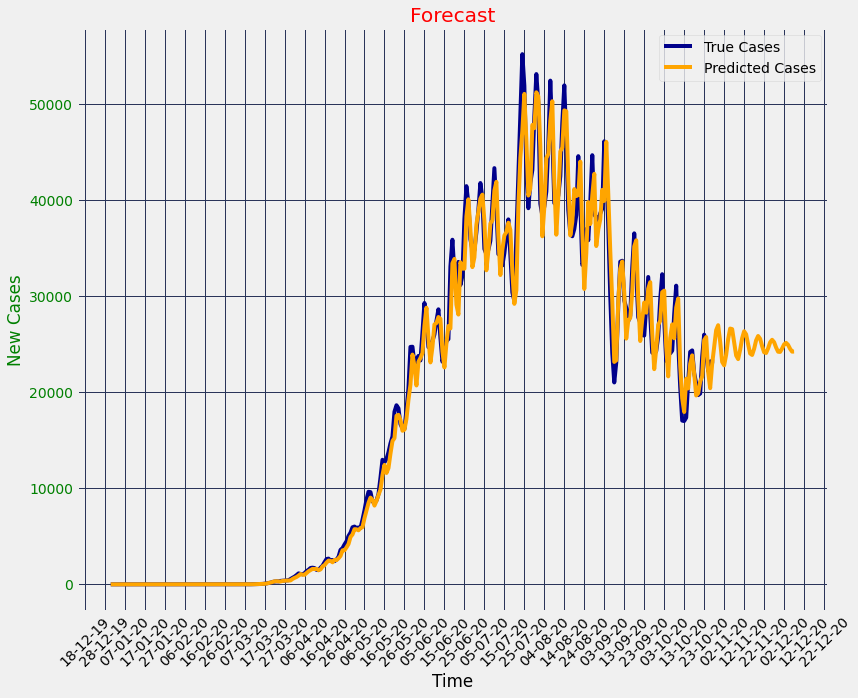

(0.10349504828279261,
 0.08386687687753908,
 array([8.39010925]),
 array([7.13849304]))

In [ ]:
show_plots(brazil)

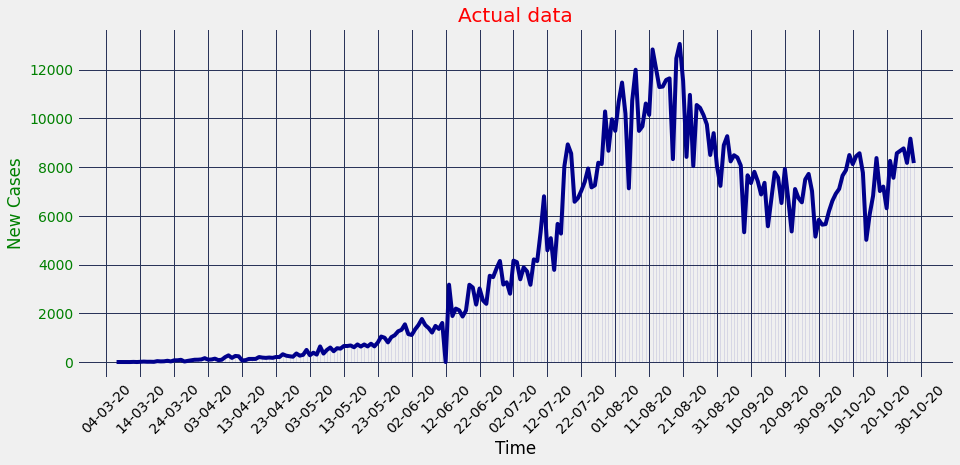

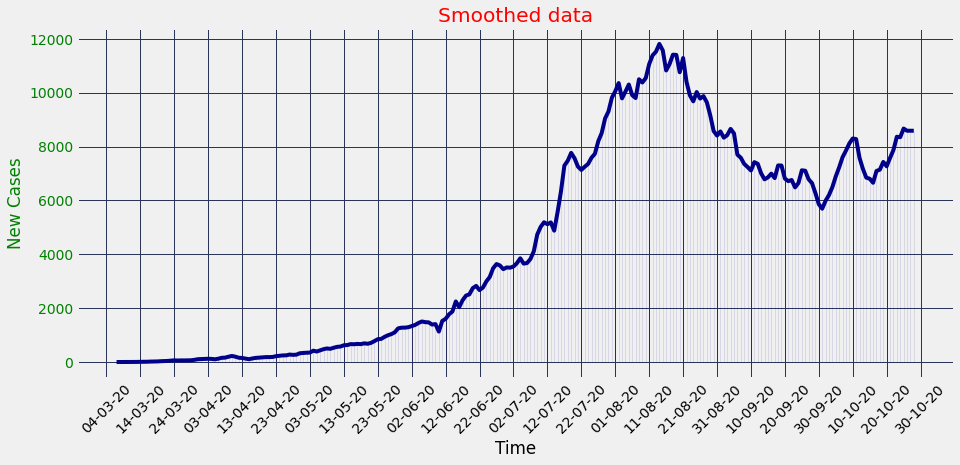

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 8, 50)             7950      
_________________________________________________________________
gru_1 (GRU)                  (None, 20)                4320      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 12,291
Trainable params: 12,291
Non-trainable params: 0
_________________________________________________________________


In [ ]:
starting_date = "07032020"
colombia = timeSeriesPredict("Colombia")
country = colombia
country.series,country.dates = get_series('/content/Colombia.csv')
plot(country.series,country.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
country.series = moving_average(country.series,5)
plot(country.series,country.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
country.x,country.y = create_windowed_dataset(country.series,8,0)
country.x_train,country.x_val,country.y_train,country.y_val = train_test_split(ratio,country.x,country.y)
country.model = get_model()
country.model.summary()
country.epochs = 500
country.split_time = int(country.x.shape[0] * ratio)

In [ ]:
train_model(country)

Epoch 1/500
1/1 [==============================] - 0s 322ms/step - loss: 33635320.0000 - mse: 33635320.0000 - val_loss: 60028204.0000 - val_mse: 60028204.0000
Epoch 2/500
1/1 [==============================] - 0s 21ms/step - loss: 31136304.0000 - mse: 31136304.0000 - val_loss: 58056636.0000 - val_mse: 58056636.0000
Epoch 3/500
1/1 [==============================] - 0s 21ms/step - loss: 30114930.0000 - mse: 30114930.0000 - val_loss: 55761548.0000 - val_mse: 55761548.0000
Epoch 4/500
1/1 [==============================] - 0s 20ms/step - loss: 28805904.0000 - mse: 28805904.0000 - val_loss: 52963520.0000 - val_mse: 52963520.0000
Epoch 5/500
1/1 [==============================] - 0s 19ms/step - loss: 27245542.0000 - mse: 27245542.0000 - val_loss: 50255344.0000 - val_mse: 50255344.0000
Epoch 6/500
1/1 [==============================] - 0s 19ms/step - loss: 25868308.0000 - mse: 25868308.0000 - val_loss: 47286960.0000 - val_mse: 47286960.0000
Epoch 7/500
1/1 [==============================] - 

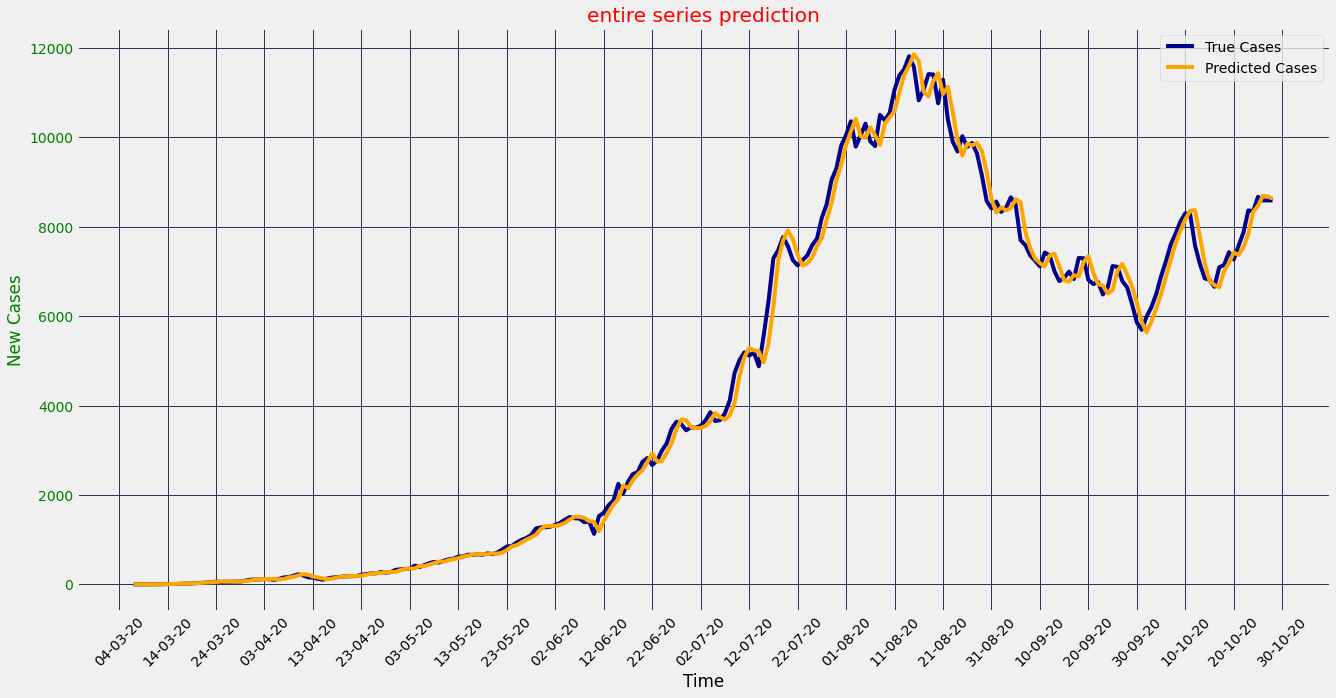

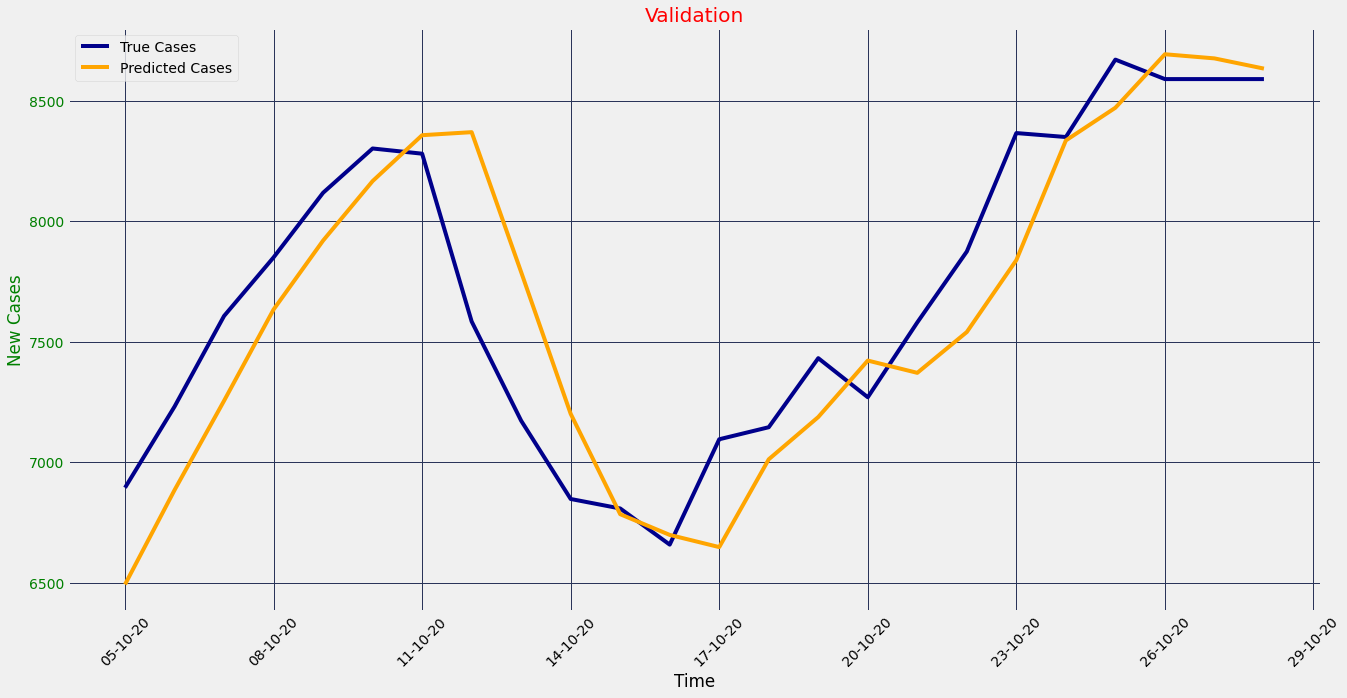

(236, 1)


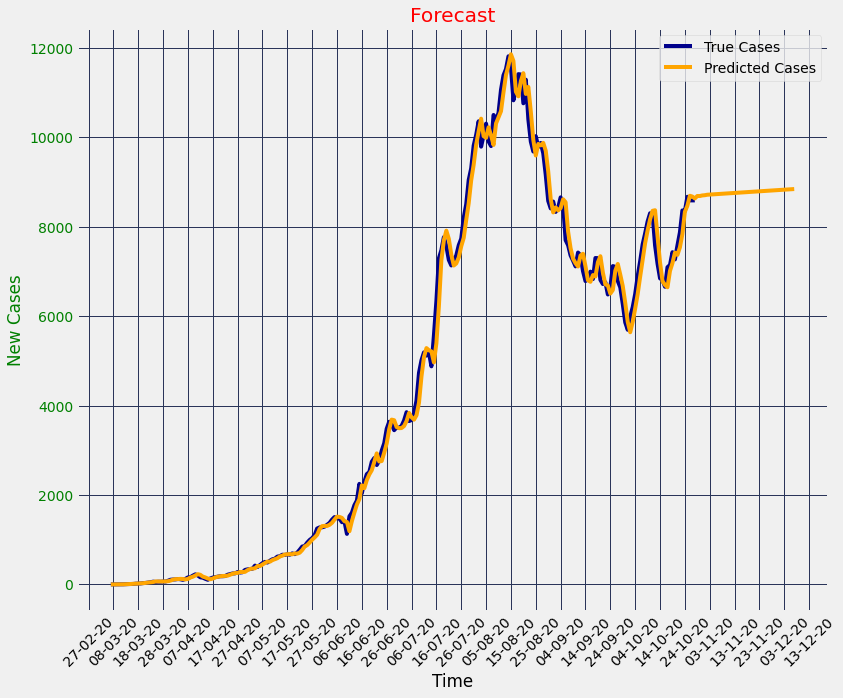

(0.06134995983122239,
 0.041683127390378286,
 array([5.96152989]),
 array([3.33804532]))

In [ ]:
show_plots(colombia)

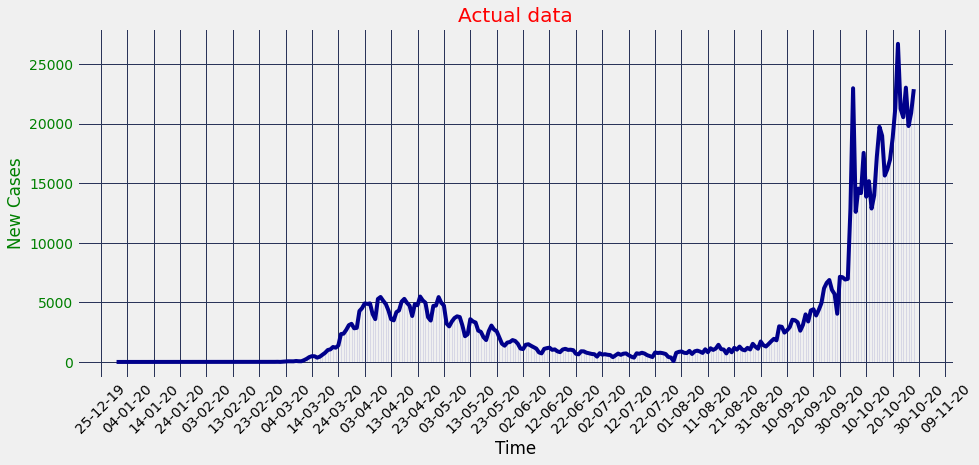

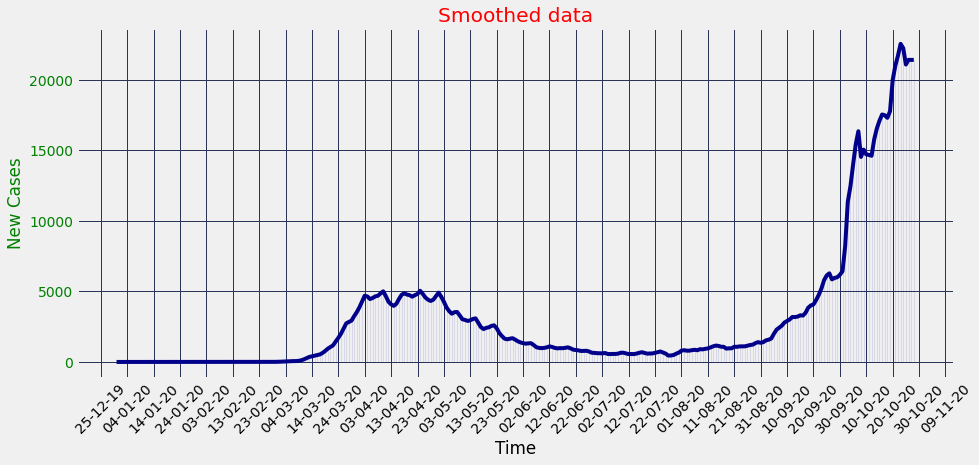

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 8, 50)             7950      
_________________________________________________________________
gru_1 (GRU)                  (None, 20)                4320      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 12,291
Trainable params: 12,291
Non-trainable params: 0
_________________________________________________________________


In [ ]:
starting_date = "31122019"
uk = timeSeriesPredict("UK")
country = uk
country.series,country.dates = get_series('/content/United Kingdom.csv')
plot(country.series,country.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
country.series = moving_average(country.series,5)
plot(country.series,country.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
country.x,country.y = create_windowed_dataset(country.series,window_size,0)
country.x_train,country.x_val,country.y_train,country.y_val = train_test_split(ratio,country.x,country.y)
country.model = get_model()
country.model.summary()
country.epochs = 1000
country.split_time = int(country.x.shape[0] * ratio)

In [ ]:
train_model(country)

Epoch 1/1000
1/1 [==============================] - 0s 370ms/step - loss: 4441587.5000 - mse: 4441587.5000 - val_loss: 211533280.0000 - val_mse: 211533280.0000
Epoch 2/1000
1/1 [==============================] - 0s 27ms/step - loss: 4039631.0000 - mse: 4039631.0000 - val_loss: 203740592.0000 - val_mse: 203740592.0000
Epoch 3/1000
1/1 [==============================] - 0s 25ms/step - loss: 3882132.2500 - mse: 3882132.2500 - val_loss: 192363808.0000 - val_mse: 192363808.0000
Epoch 4/1000
1/1 [==============================] - 0s 25ms/step - loss: 3650781.2500 - mse: 3650781.2500 - val_loss: 142364640.0000 - val_mse: 142364640.0000
Epoch 5/1000
1/1 [==============================] - 0s 25ms/step - loss: 2717191.0000 - mse: 2717191.0000 - val_loss: 112817088.0000 - val_mse: 112817088.0000
Epoch 6/1000
1/1 [==============================] - 0s 24ms/step - loss: 2094882.3750 - mse: 2094882.3750 - val_loss: 72612096.0000 - val_mse: 72612096.0000
Epoch 7/1000
1/1 [=============================

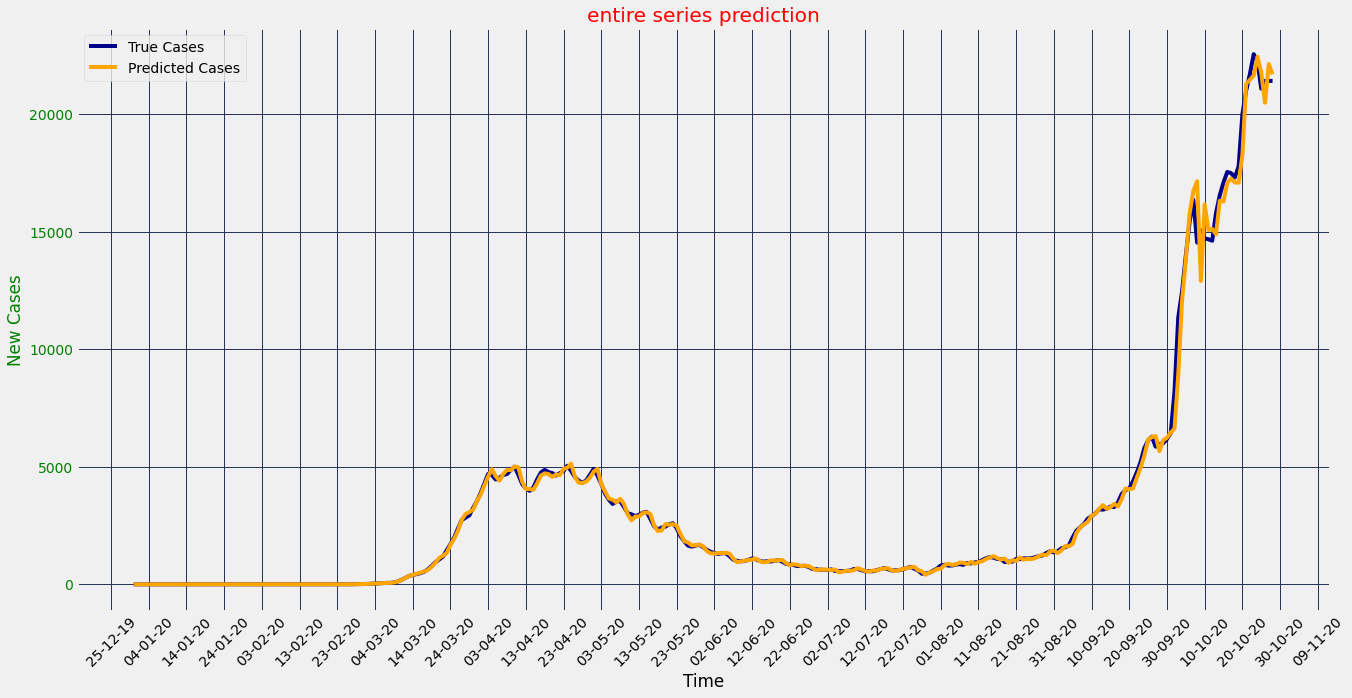

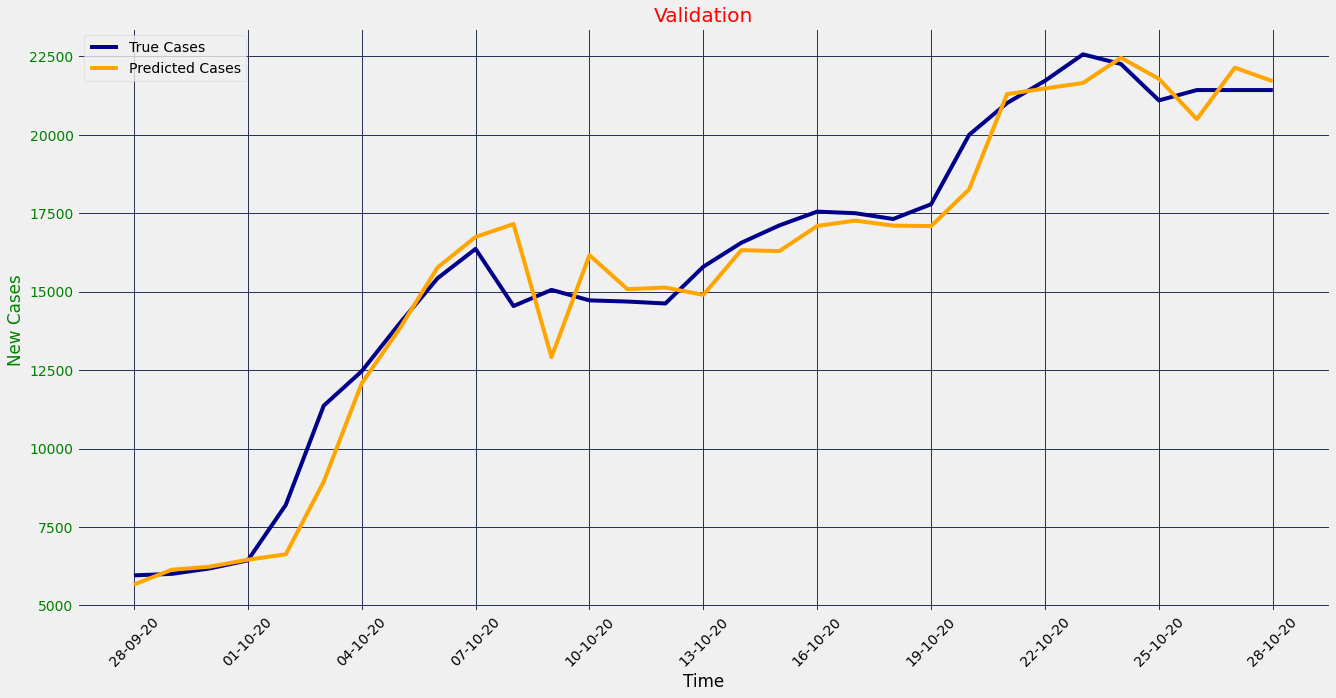

(303, 1)


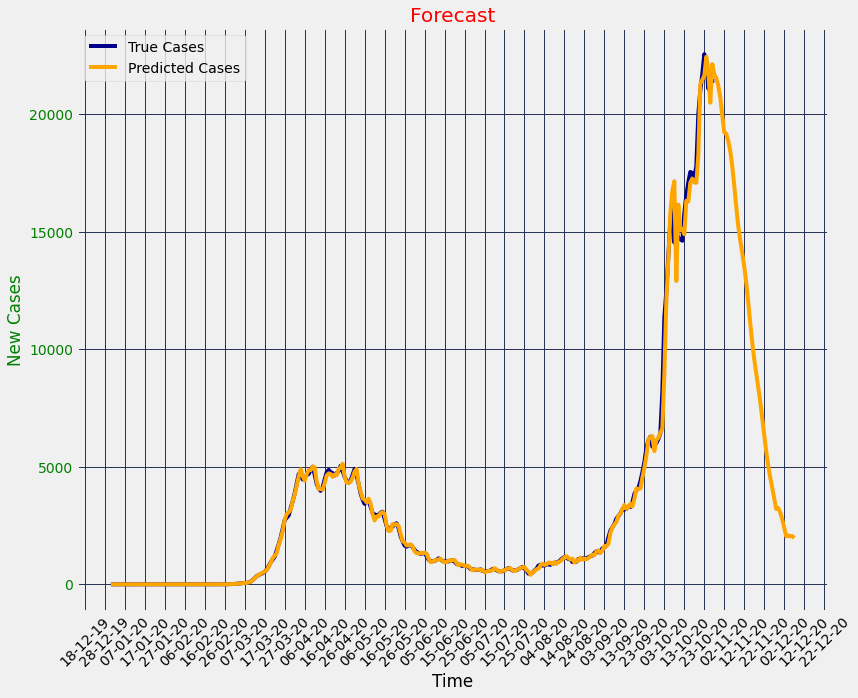

(0.10985938839247225,
 0.06435660892114797,
 array([7.00403597]),
 array([5.00403751]))

In [ ]:
show_plots(uk)

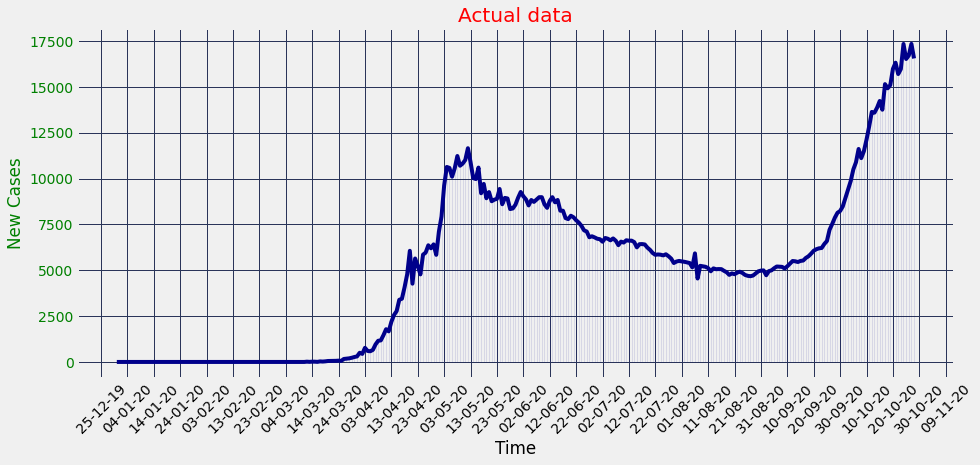

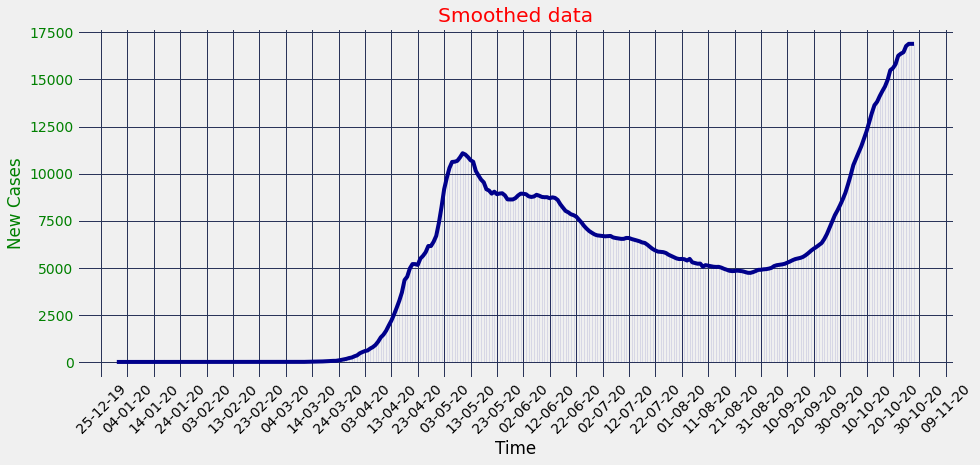

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 8, 50)             7950      
_________________________________________________________________
gru_1 (GRU)                  (None, 20)                4320      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 12,291
Trainable params: 12,291
Non-trainable params: 0
_________________________________________________________________


In [ ]:
starting_date = "31122019"
russia = timeSeriesPredict("Russia")
country = russia
country.series,country.dates = get_series('/content/Russia.csv')
plot(country.series,country.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
country.series = moving_average(country.series,5)
plot(country.series,country.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
country.x,country.y = create_windowed_dataset(country.series,10,0)
country.x_train,country.x_val,country.y_train,country.y_val = train_test_split(ratio,country.x,country.y)
country.model = get_model()
country.model.summary()
country.epochs = 1000
country.split_time = int(country.x.shape[0] * ratio)

In [ ]:
train_model(country)

Epoch 1/1000
1/1 [==============================] - 0s 334ms/step - loss: 33475494.0000 - mse: 33475494.0000 - val_loss: 190429152.0000 - val_mse: 190429152.0000
Epoch 2/1000
1/1 [==============================] - 0s 23ms/step - loss: 32297814.0000 - mse: 32297814.0000 - val_loss: 185480032.0000 - val_mse: 185480032.0000
Epoch 3/1000
1/1 [==============================] - 0s 20ms/step - loss: 31401916.0000 - mse: 31401916.0000 - val_loss: 178695696.0000 - val_mse: 178695696.0000
Epoch 4/1000
1/1 [==============================] - 0s 21ms/step - loss: 30256394.0000 - mse: 30256394.0000 - val_loss: 172223600.0000 - val_mse: 172223600.0000
Epoch 5/1000
1/1 [==============================] - 0s 19ms/step - loss: 29100560.0000 - mse: 29100560.0000 - val_loss: 166425328.0000 - val_mse: 166425328.0000
Epoch 6/1000
1/1 [==============================] - 0s 22ms/step - loss: 28087160.0000 - mse: 28087160.0000 - val_loss: 152844912.0000 - val_mse: 152844912.0000
Epoch 7/1000
1/1 [===============

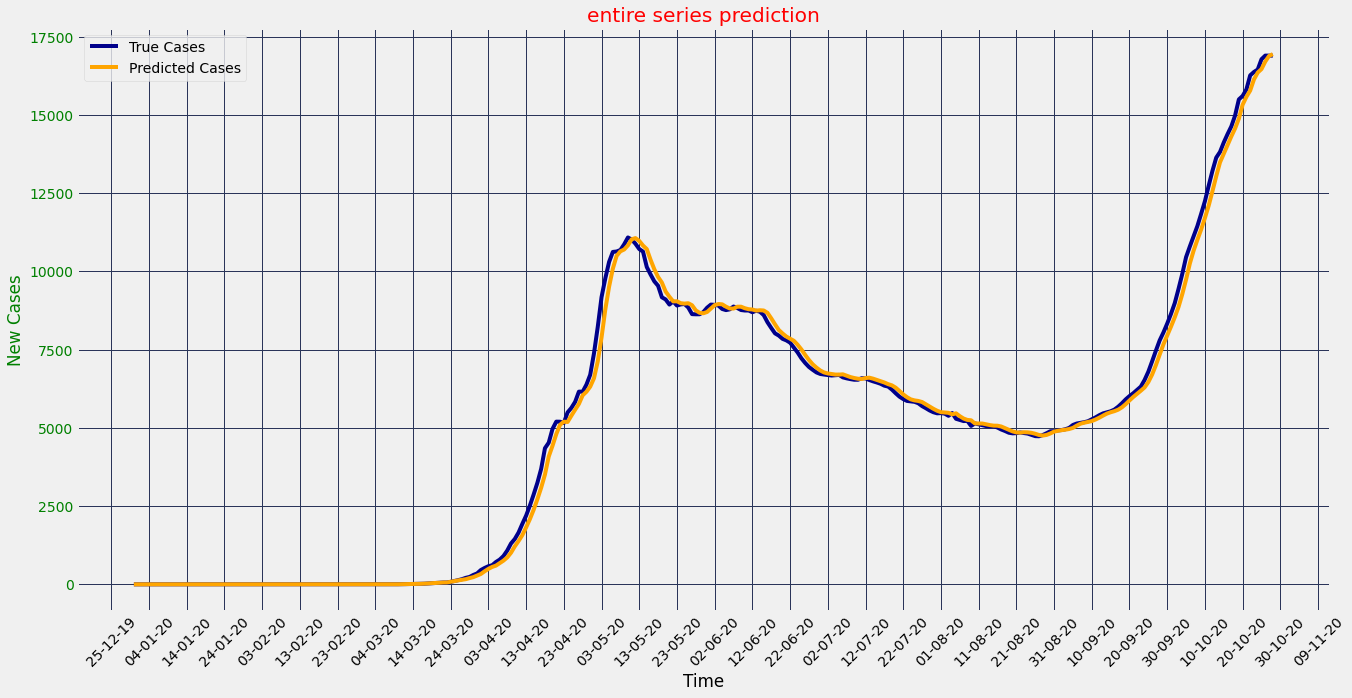

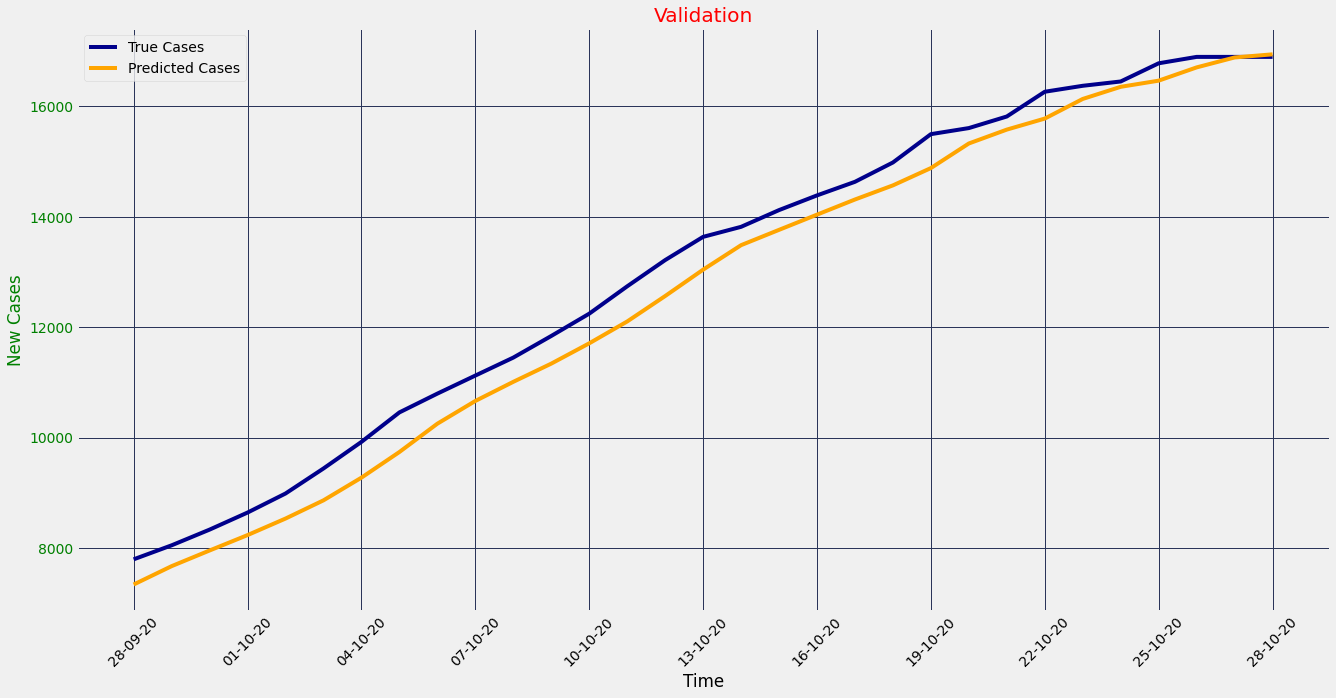

(303, 1)


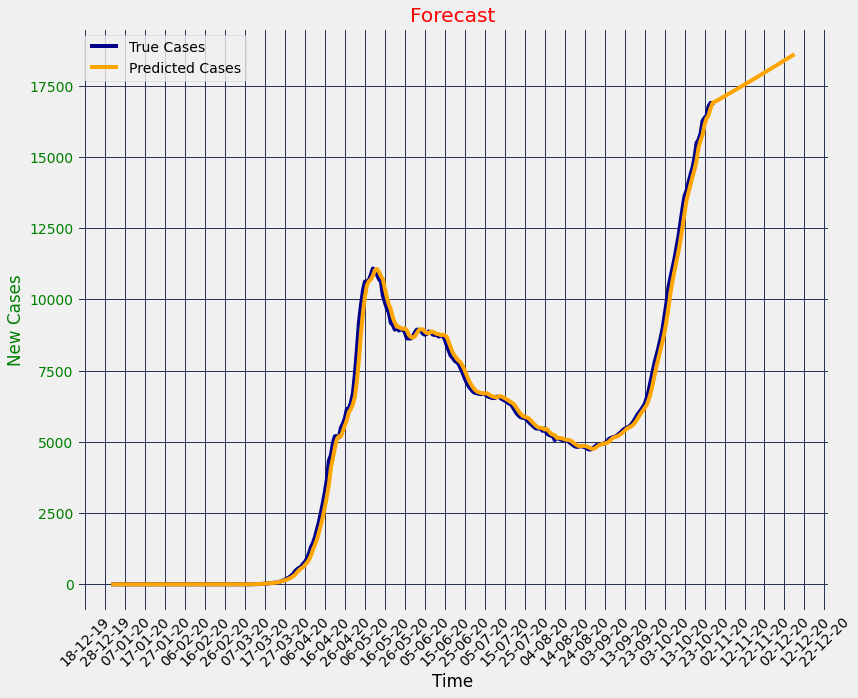

(0.04927580400143261,
 0.03524694055780942,
 array([5.7625309]),
 array([3.4908065]))

In [ ]:
show_plots(russia)

In [ ]:
# model = tf.keras.Sequential([
                               
  #                              Conv1D(32,3,1,input_shape=(window_size,n_features)),
  #                              BatchNormalization(),
  #                              Activation('relu'),
  #                              Conv1D(64,3,1),
  #                              BatchNormalization(),
  #                              Activation('relu'),
  #                              Conv1D(128,3,1),
  #                              BatchNormalization(),
  #                              Activation('relu'),
  #                              Conv1D(256,3,1),
  #                              BatchNormalization(),
  #                              Activation('relu'),
  #                             #  Conv1D(512,3,1,activation='relu'),
  #                             #  BatchNormalization(),
  #                             #  Activation('relu'),
  #                             #  Conv1D(1024,3,1,activation='relu'),
  #                              Flatten(),
  #                             #  Dense(100),
  #                              Dense(10),
  #                              BatchNormalization(),
  #                              Activation('relu'),
  #                              Dense(1,activation='relu')
  # ])

  # input = Input(shape=(window_size,n_features))
  # x = Conv1D(32,3,1)(input)
  # # x = BatchNormalization()(x)
  # x = Activation('relu')(x)
  # x = inception_A(x)
  # x = Conv1D(64,3,1)(x)
  # # x = BatchNormalization()(x)
  # x = Activation('relu')(x)
  # x = inception_A(x)
  # x = Conv1D(128,3,1)(x)
  # # x = BatchNormalization()(x)
  # x = Activation('relu')(x)
  # x = inception_A(x)
  # x = Conv1D(256,3,1)(x)
  # # x = BatchNormalization()(x)
  # x = Activation('relu')(x)
  # # x = LSTM(8)(x)
  # x = Flatten()(x)
  # x = Dense(10)(x)
  # # x = BatchNormalization()(x)
  # x = Activation('relu')(x)
  # x = Dense(1,activation='relu')(x)

  # model = Model(input,x)